### Что должны получить на выходе?

Мы должны посчитать суммарный объем для каждой акции, который был заработан во время ее проведения. 

Мы обучим модель предсказывать количество литров каждого напитка, который был дополнительно приобретен благодаря только этой акции. Для каждой акции будем рассматривать все напитки, не только те, на которые была скидка во время ее проведения, потому что могут быть побочные эффекты. Например если скидка на виски, то увеличится продажа колы и т.д.

### Что должна делать модель?

Модель должна на основании имеющихся данных спрогнозировать объем напитка, который будет продан в конкретную дату в конкретном городе.


In [390]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [391]:
pd.set_option('display.float_format', lambda x: '%.6f' %x)

In [392]:
daily_df = pd.read_parquet('src/daily_volume.parquet', engine='fastparquet')
effect_df = pd.read_parquet('src/effect.parquet', engine='fastparquet')
sales_df = pd.read_parquet('src/sales.parquet', engine='fastparquet')
attack_df = pd.read_parquet('src/attack_probability.parquet', engine='fastparquet')
promo_df = pd.read_parquet('src/promo.parquet', engine='fastparquet')
drinks_df = pd.read_parquet('src/drinks.parquet', engine='fastparquet')

### Изучаем таблицу daily_volume.parquet

In [393]:
daily_df.head()

,city,id,product,date,volume_litr
0,Коукворт,5429785,Эгног,1997-12-21,13.817442
1,Коукворт,6204483,Смородиновый ром,1997-12-21,2.744815
2,Авимор,8468669,Смородиновый ром,1997-12-21,0.625733
3,Литтл Уингинг,3750132,Огненный виски,1997-12-21,4.666352
4,Салем,7578185,Смородиновый ром,1997-12-21,0.185256


In [394]:
daily_df.describe()

,id,volume_litr
count,3778274.000000,3778274.000000
mean,4999594.946165,21.801247
std,2888362.666429,19.581181
min,6.000000,0.000000
25%,2495717.250000,6.478835
50%,4997228.000000,16.007662
75%,7504063.750000,31.995873
max,9999993.000000,270.000000


In [395]:
daily_df.shape

(3778274, 5)

In [396]:
daily_df.isnull().sum()

city           0
id             0
product        0
date           0
volume_litr    0
dtype: int64

Всего 3778174 записей и нет пропущенных значений

**Проверим типы данных столбцов**

In [397]:
daily_df.dtypes

city            object
id               int64
product         object
date            object
volume_litr    float64
dtype: object

 Столбец date имеет тип данных 'object'. Исправим его на 'datetime'

In [398]:
daily_df['date'] = pd.to_datetime(daily_df['date'])
daily_df.dtypes

city                   object
id                      int64
product                object
date           datetime64[ns]
volume_litr           float64
dtype: object

**Посмотрим о каких городах есть информация**

In [399]:
daily_df.city.unique()

array(['Коукворт', 'Авимор', 'Литтл Уингинг', 'Салем', 'Нью-Йорк',
       'Кромер', 'Бат', 'Париж', 'Абердин', 'Даффтаун', 'Лондон'],
      dtype=object)

In [400]:
daily_df.city.unique().size

11

Всего есть 11 городов.

In [401]:
CITIES_NUMBER = len(daily_df.city.unique())

**Изучим ассортимент напитков**

In [402]:
daily_df['product'].unique()

array(['Эгног', 'Смородиновый ром', 'Огненный виски', 'Чешуя дракона',
       'Сливочное пиво', 'Горная вода', 'Языкосвязывающий лимонный сквош',
       'Шипучий персиковый чай', 'Тыквенный сок', 'Настой тыквы'],
      dtype=object)

In [403]:
daily_df['product'].unique().size

10

In [404]:
DRINKS_NUMBER = daily_df['product'].unique().size

Всего 10 видов напитков

**Проверим данные о датах реализации**

In [405]:
daily_df.date.min()

Timestamp('1996-01-01 00:00:00')

In [406]:
daily_df.date.max()

Timestamp('1997-12-31 00:00:00')

In [407]:
daily_df.date.unique().size

731

Имеются данные о реализации за каждый день в течении 2 лет с 1 января 1996 года до 31 декабря 1997 года

**Проверим данные о заведениях**

In [408]:
daily_df.id.unique().size

3145660

О большистве заведений имеется не больше одной записи о реализации в таблице, не имеет смысла рассматривать реализацию каждого заведения. Будем работать с реализацией по городам. Поэтому избавимся от столбца с id заведений, но так чтобы не потерять и не добавить лишних данных. 

In [409]:
daily_df.head()

,city,id,product,date,volume_litr
0,Коукворт,5429785,Эгног,1997-12-21,13.817442
1,Коукворт,6204483,Смородиновый ром,1997-12-21,2.744815
2,Авимор,8468669,Смородиновый ром,1997-12-21,0.625733
3,Литтл Уингинг,3750132,Огненный виски,1997-12-21,4.666352
4,Салем,7578185,Смородиновый ром,1997-12-21,0.185256


Нам нужно объединить объем записей за одну и ту же дату с одинаковыми городами, напитками. Для этого сгруппируем записи по городу, напитку, дате и просуммируем объем. Также, удалим сразу столбец с id заведений.

In [410]:
temp_df = daily_df.groupby(['city','date','product']).sum().reset_index().drop('id',axis = 1)
temp_df.head()

,city,date,product,volume_litr
0,Абердин,1996-01-01,Горная вода,141.007667
1,Абердин,1996-01-01,Огненный виски,255.188103
2,Абердин,1996-01-01,Сливочное пиво,1119.927917
3,Абердин,1996-01-01,Смородиновый ром,26.628389
4,Абердин,1996-01-01,Чешуя дракона,492.548590


Проверим правильно ли объединили записи.

In [411]:
temp_df.groupby(['city','date','product']).count()['volume_litr'].max()

1

In [412]:
daily_df.loc[(daily_df['city']=='Абердин') & (daily_df['date']=='1996-01-01') & (daily_df['product']=='Сливочное пиво')]['volume_litr'].sum()

1119.9279171187522

In [413]:
temp_df.loc[
    (temp_df['city']=='Абердин') & (temp_df['date']=='1996-01-01') & (temp_df['product']=='Сливочное пиво')    
]['volume_litr']

2   1119.927917
Name: volume_litr, dtype: float64

Все верно. Изменим первоначальный датафрейм.

In [414]:
daily_df = temp_df
daily_df

,city,date,product,volume_litr
0,Абердин,1996-01-01,Горная вода,141.007667
1,Абердин,1996-01-01,Огненный виски,255.188103
2,Абердин,1996-01-01,Сливочное пиво,1119.927917
3,Абердин,1996-01-01,Смородиновый ром,26.628389
4,Абердин,1996-01-01,Чешуя дракона,492.548590
...,...,...,...,...
49571,Салем,1997-12-31,Горная вода,1654.001331
49572,Салем,1997-12-31,Огненный виски,1365.207233
49573,Салем,1997-12-31,Сливочное пиво,3790.941219
49574,Салем,1997-12-31,Смородиновый ром,241.840409


**Используя данные таблицы drinks.parquete, добавим столбец показывающий является ли напиток алкогольным или напиток или нет**

In [415]:
drinks_df.head()

,Напиток,Тип
0,Языкосвязывающий лимонный сквош,Безалкогольный
1,Сливочное пиво,Алкогольный
2,Шипучий персиковый чай,Безалкогольный
3,Чешуя дракона,Алкогольный
4,Эгног,Безалкогольный


In [416]:
drinks_dict = drinks_df.set_index('Напиток').to_dict()['Тип']

daily_df['alcohol'] = daily_df['product'] 
daily_df = daily_df.replace({'alcohol':drinks_dict})
daily_df.head()

,city,date,product,volume_litr,alcohol
0,Абердин,1996-01-01,Горная вода,141.007667,Безалкогольный
1,Абердин,1996-01-01,Огненный виски,255.188103,Алкогольный
2,Абердин,1996-01-01,Сливочное пиво,1119.927917,Алкогольный
3,Абердин,1996-01-01,Смородиновый ром,26.628389,Алкогольный
4,Абердин,1996-01-01,Чешуя дракона,492.548590,Алкогольный


**Добавим данные о вероятности нападения**

In [417]:
attack_df.head()

,Unnamed: 0,city,date,attack probability
0,0,Коукворт,1996-02-23,0.163317
1,1,Коукворт,1996-02-24,0.219221
2,2,Коукворт,1996-02-25,0.180625
3,3,Коукворт,1996-02-26,0.149749
4,4,Коукворт,1996-02-27,0.121288


In [418]:
del attack_df['Unnamed: 0']

In [419]:
attack_df.dtypes

city                   object
date                   object
attack probability    float64
dtype: object

In [420]:
attack_df['date'] = pd.to_datetime(attack_df['date'])
attack_df.dtypes

city                          object
date                  datetime64[ns]
attack probability           float64
dtype: object

In [421]:
attack_df.describe()

,attack probability
count,3685.000000
mean,0.272010
std,0.198836
min,0.000000
25%,0.120603
50%,0.204634
75%,0.356784
max,1.000000


In [422]:
daily_df = daily_df.merge(attack_df, how = 'left', on = ['date','city'])
daily_df.head()

,city,date,product,volume_litr,alcohol,attack probability
0,Абердин,1996-01-01,Горная вода,141.007667,Безалкогольный,NaN
1,Абердин,1996-01-01,Огненный виски,255.188103,Алкогольный,NaN
2,Абердин,1996-01-01,Сливочное пиво,1119.927917,Алкогольный,NaN
3,Абердин,1996-01-01,Смородиновый ром,26.628389,Алкогольный,NaN
4,Абердин,1996-01-01,Чешуя дракона,492.548590,Алкогольный,NaN


In [423]:
daily_df.count()

city                  49576
date                  49576
product               49576
volume_litr           49576
alcohol               49576
attack probability    23176
dtype: int64

Данные о вероятности нападения есть только у чуть меньше половины записей. Это нужно будет учесть при построении модели

**Визуализируем на графике суммарный объем реализации каждого из напитков за 2 года**

C:\Users\Denis\AppData\Local\Temp\ipykernel_9000\4135785839.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  bplt = sns.barplot(data = daily_df.groupby('product').sum().reset_index(),


[Text(0, 0, 'Горная вода'),
 Text(1, 0, 'Настой тыквы'),
 Text(2, 0, 'Огненный виски'),
 Text(3, 0, 'Сливочное пиво'),
 Text(4, 0, 'Смородиновый ром'),
 Text(5, 0, 'Тыквенный сок'),
 Text(6, 0, 'Чешуя дракона'),
 Text(7, 0, 'Шипучий персиковый чай'),
 Text(8, 0, 'Эгног'),
 Text(9, 0, 'Языкосвязывающий лимонный сквош')]

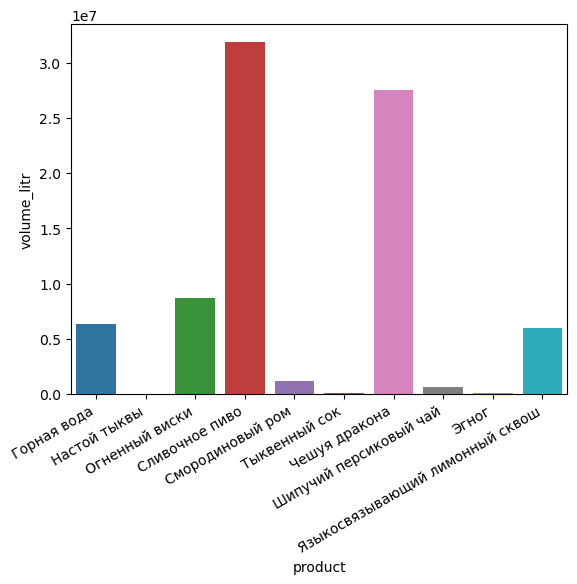

In [424]:
bplt = sns.barplot(data = daily_df.groupby('product').sum().reset_index(), 
            x = 'product', 
            y = 'volume_litr'
           )
bplt.set_xticklabels(bplt.get_xticklabels(), rotation=30, horizontalalignment='right')

**График изменения объема продаж разных напитков за 2 года, отдельно для каждого города.**

c:\Users\Denis\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Denis\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Denis\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Denis\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Denis\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be r

<Figure size 640x480 with 0 Axes>

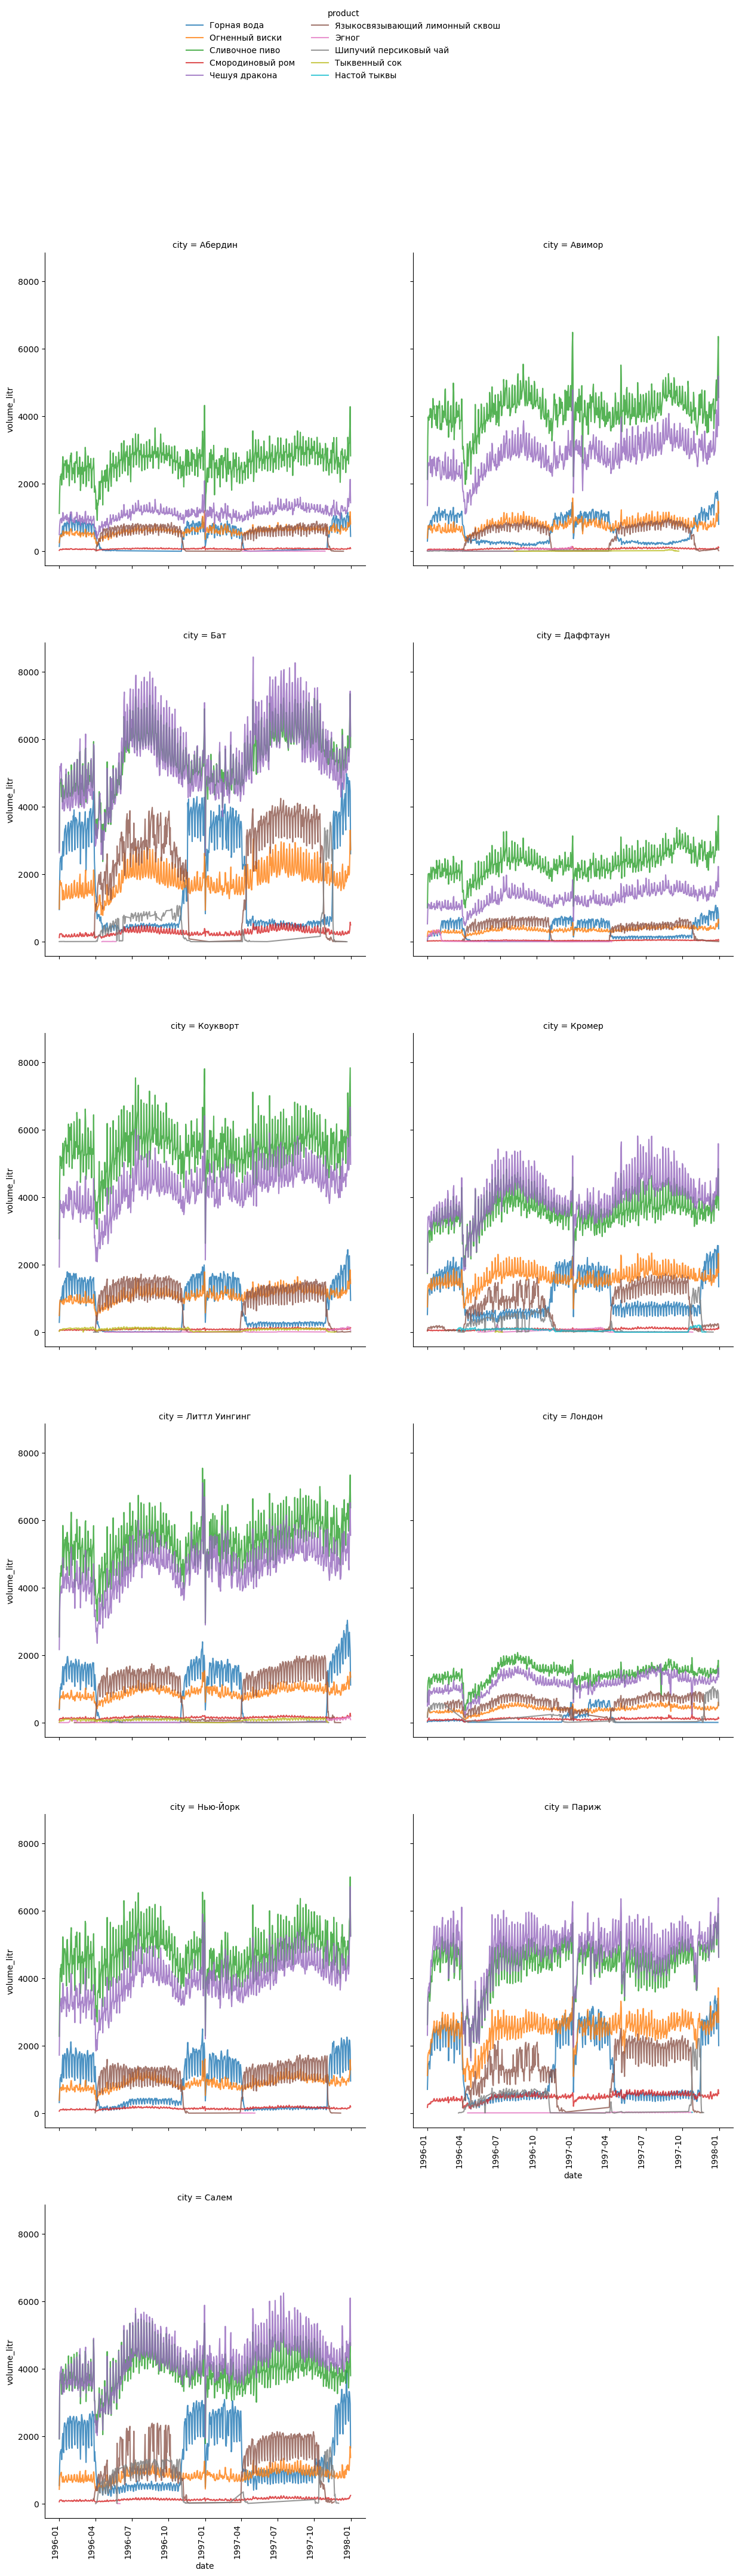

<Figure size 640x480 with 0 Axes>

In [425]:
grid = sns.FacetGrid (data = daily_df, col = 'city', hue = 'product', col_wrap = 2)
grid.map(sns.lineplot, 'date', 'volume_litr',  alpha  = 0.8)
grid.add_legend(ncol=2, loc = 'lower center', bbox_to_anchor=(0.3,1.05))
grid.set_xticklabels(rotation=90, horizontalalignment='right')
grid.fig.set_figwidth(30)
grid.fig.set_figheight(40)
plt.figure()

**График изменения объема продаж по городам за 2 года, отдельно для каждого напитка.**

c:\Users\Denis\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Denis\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Denis\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Denis\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Denis\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be r

<Figure size 640x480 with 0 Axes>

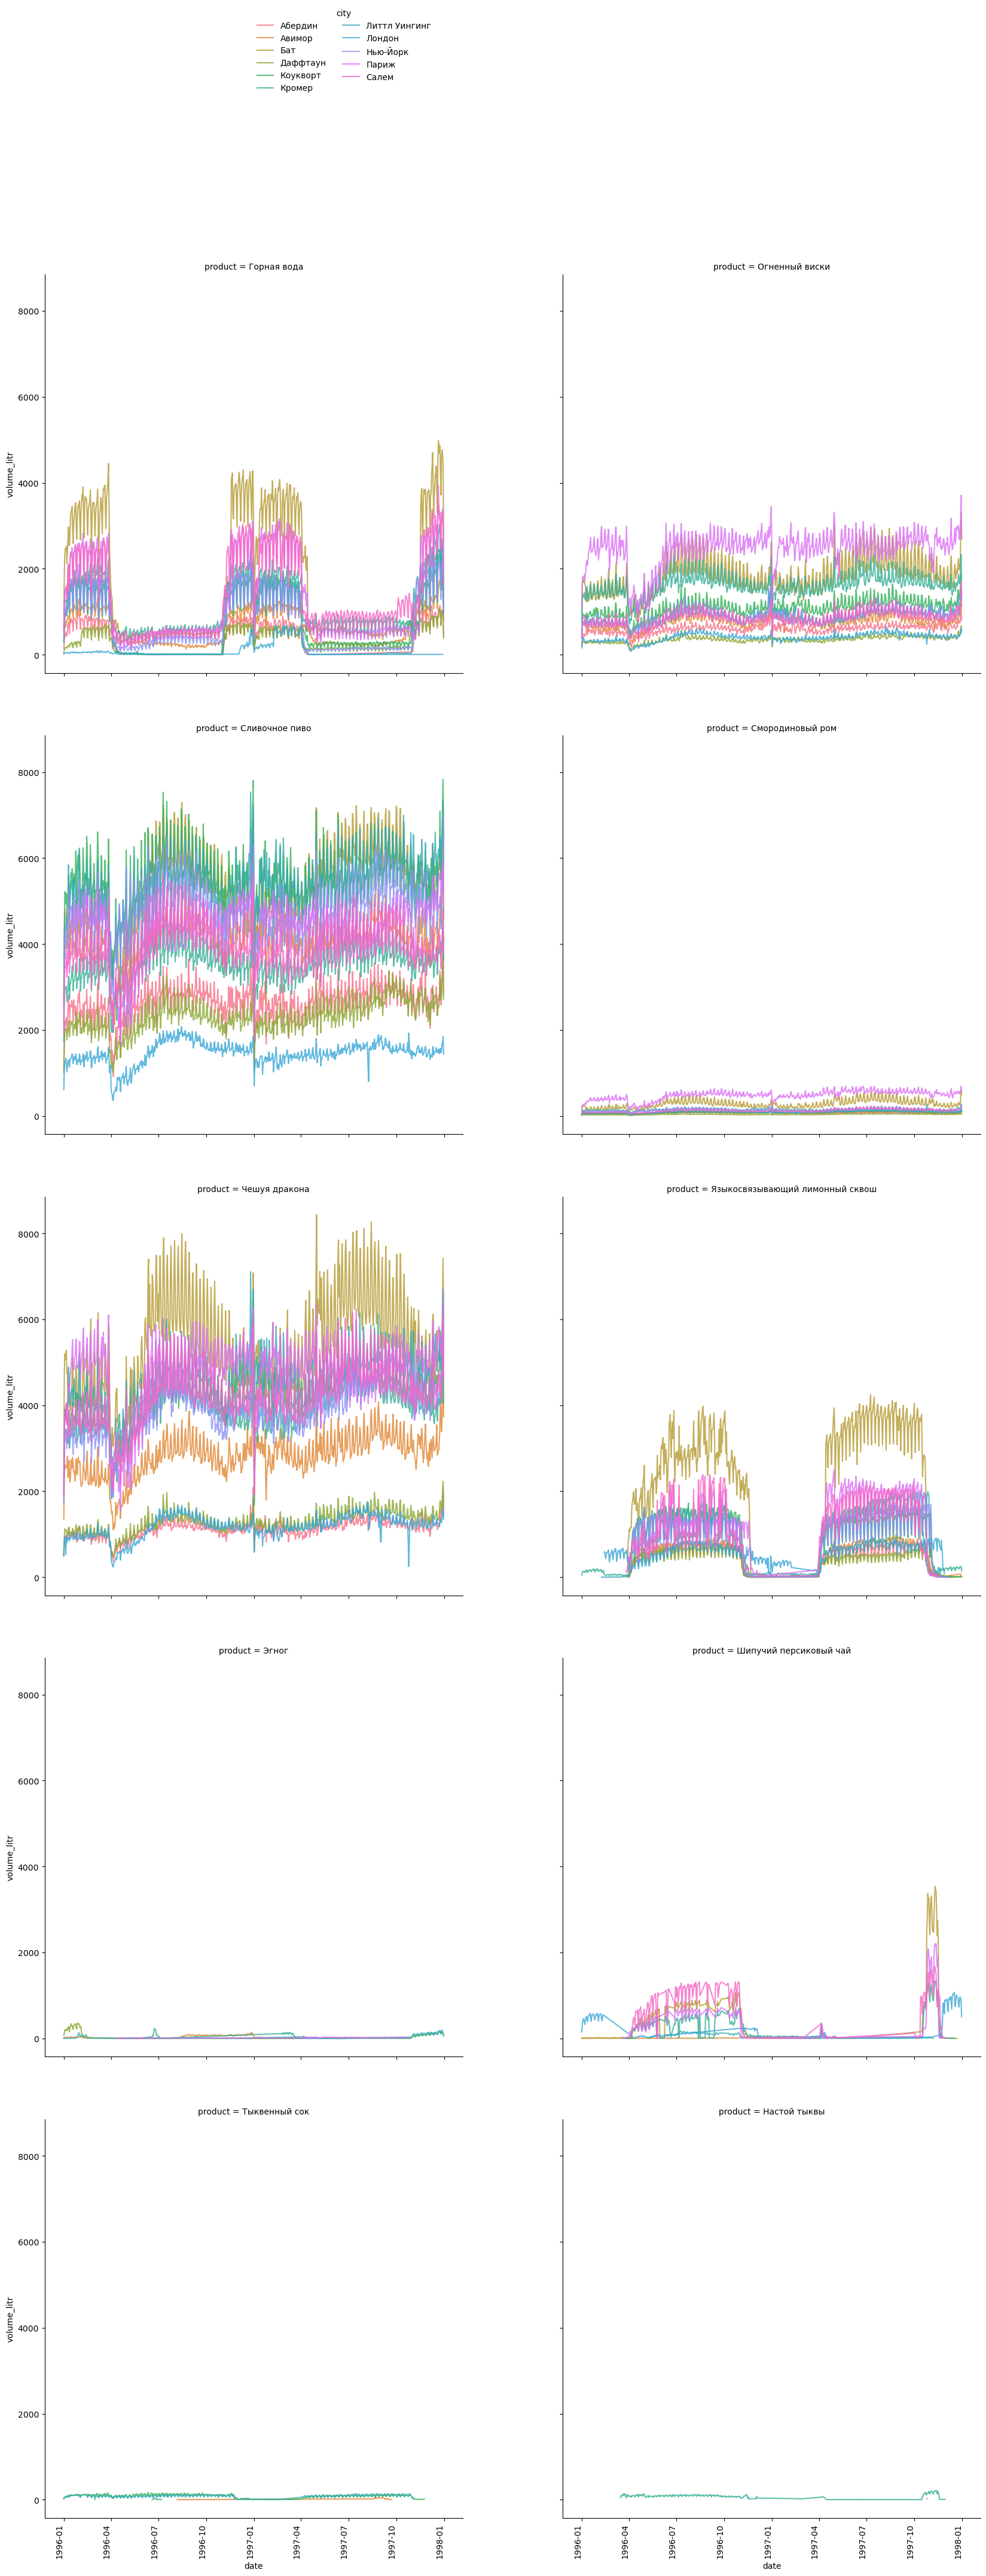

<Figure size 640x480 with 0 Axes>

In [426]:
grid = sns.FacetGrid (data = daily_df, col = 'product', hue = 'city', col_wrap = 2)
grid.map(sns.lineplot, 'date', 'volume_litr',  alpha  = 0.8)
grid.add_legend(ncol=2, loc = 'lower center', bbox_to_anchor=(0.3,1.05))
grid.set_xticklabels(rotation=90, horizontalalignment='right')
grid.fig.set_figwidth(30)
grid.fig.set_figheight(40)
plt.figure()

На основании построенных графиков можно сделать вывод, что существуют общие тенденции роста или падения объемов продаж для всех напитков в каждом городе. Например, резкий спад объемов реализации всех напитков во всех городах в районе апреля-мая 1996 года, или резкий скачок в начале января 1997 года. Также, 3 самых продаваемых напитка ("Сливочное пиво", "Чешуя дракона", "огненный виски") имеют примерно одинаковую динамику продаж в каждом городе. Также, продажи одного и того же напитка в разных городах имеют одинаковую динамику продаж.  

**Посмотрим есть ли зависимость объема реализации от вероятности нападения**

c:\Users\Denis\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Denis\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Denis\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Denis\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Denis\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be r

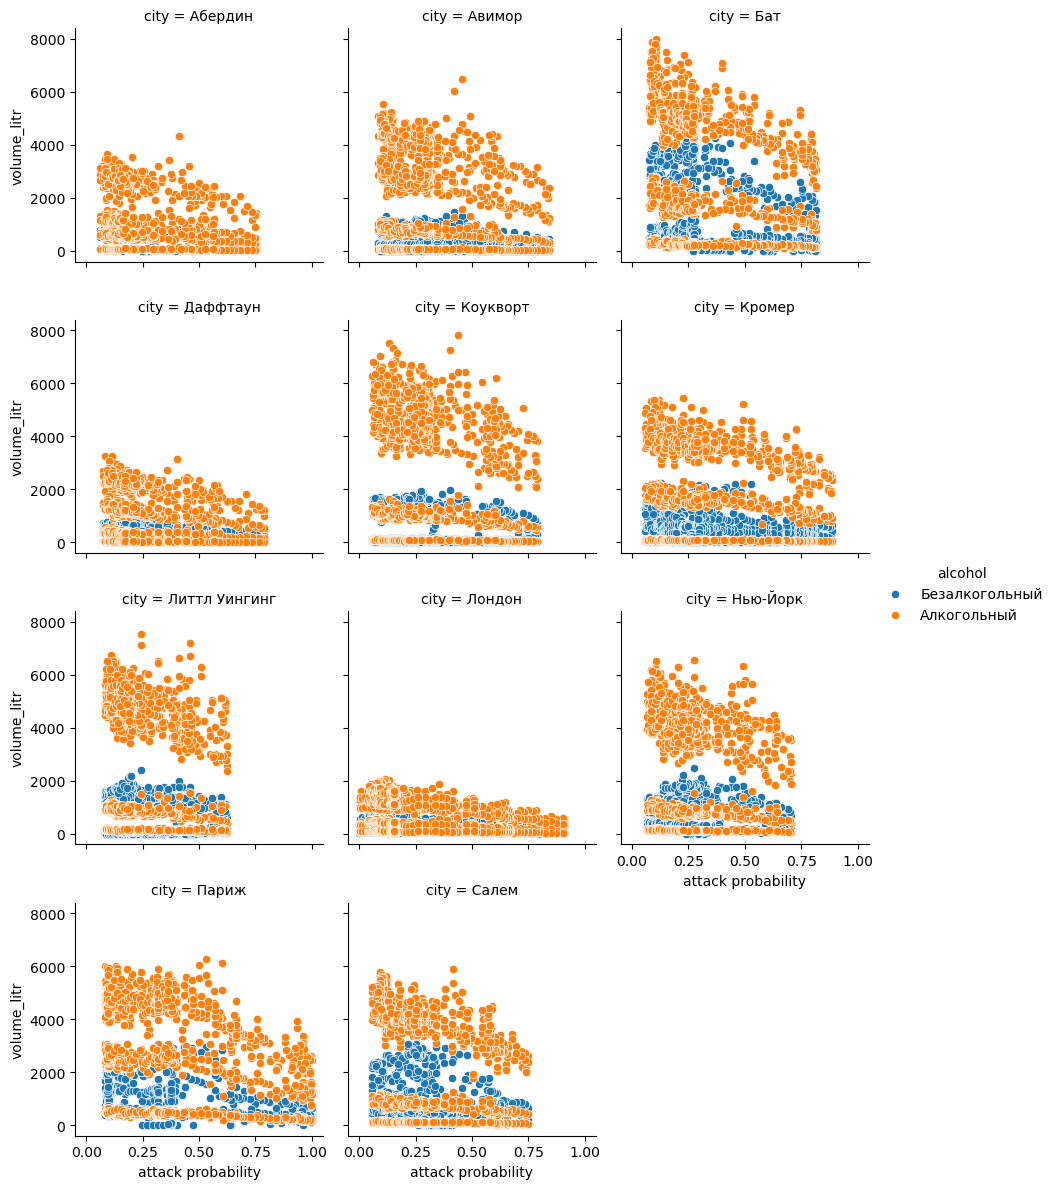

In [427]:
grid = sns.FacetGrid (data = daily_df, col = 'city', hue = 'alcohol', col_wrap = 3)
grid.map(sns.scatterplot, 'attack probability', 'volume_litr')
grid.add_legend()

По графикам видно наличие обратной линейной зависимости между объемом реализации и вероятностью нападения.

### Изучаем таблицу с эффектами акций

In [428]:
effect_df.head()

,date,product,city,volume_litr
0,1997-02-06,Огненный виски,Нью-Йорк,73.812644
1,1997-02-06,Смородиновый ром,Нью-Йорк,10.502700
2,1997-02-06,Огненный виски,Кромер,134.363871
3,1997-02-06,Безалкогольное,Авимор,5.823788
4,1997-02-06,Вода,Лондон,60.879819


In [429]:
effect_df.describe()

,volume_litr
count,48942.000000
mean,2.643932
std,22.192502
min,0.000000
25%,0.000009
50%,0.000104
75%,0.000761
max,598.000000


In [430]:
effect_df.shape

(48942, 4)

In [431]:
effect_df.isnull().sum()

date              0
product           0
city           3804
volume_litr       0
dtype: int64

Всего 48942 записей. В столбце city есть 3804 пропущенных значений. Посмотрим на эти записи.

In [432]:
effect_df.loc[effect_df['city'].isnull()]

,date,product,city,volume_litr
65,1996-02-10,Безалкогольное,None,0.000000
108,1996-12-30,Чешуя дракона,None,0.000000
112,1996-08-14,Вода,None,0.000000
145,1997-01-03,Сливочное пиво,None,0.000000
147,1996-10-04,Вода,None,0.000000
...,...,...,...,...
48879,1997-07-23,Огненный виски,None,0.000000
48889,1997-07-24,Чешуя дракона,None,0.000000
48897,1997-07-23,Сливочное пиво,None,0.000000
48915,1997-07-21,Чешуя дракона,None,0.000000


In [433]:
effect_df.loc[effect_df['city'].isnull()].volume_litr.sum()

0.0

In [434]:
effect_df.loc[(effect_df['volume_litr']==0) & (effect_df['city'].notna())]

,date,product,city,volume_litr
812,1996-04-12,Безалкогольное,Даффтаун,0.000000
1428,1996-01-01,Безалкогольное,Нью-Йорк,0.000000
18620,1996-03-27,Безалкогольное,Абердин,0.000000
23427,1997-01-12,Безалкогольное,Париж,0.000000


Во всех записях не имеющих значения города объем реализации равен нулю. Поэтому можно удалить такие записи (а также записи в которых есть данные о городе, но объем равен нулю), и с учетом условия задачи считать, что если об объеме эффекта какого-то напитка нет информации, значит в этом городе в эту дату акции никак не повлияли на объем его продаж.   

In [435]:
effect_df = effect_df.drop(effect_df.loc[effect_df['volume_litr']==0].index,axis = 0)

In [436]:
effect_df.isnull().sum()

date           0
product        0
city           0
volume_litr    0
dtype: int64

**Посмотрим какой период затрагивают данные, о каких городах и продуктах есть инфомация.**

In [437]:
effect_df['city'].unique()

array(['Нью-Йорк', 'Кромер', 'Авимор', 'Лондон', 'Париж', 'Бат', 'Салем',
       'Литтл Уингинг', 'Даффтаун', 'Коукворт', 'Абердин'], dtype=object)

In [438]:
effect_df['city'].unique().size

11

In [439]:
effect_df['date'].min()

'1996-01-01'

In [440]:
effect_df['date'].max()

'1997-12-31'

In [441]:
effect_df['date'].unique().size

716

In [442]:
effect_df['product'].unique()

array(['Огненный виски', 'Смородиновый ром', 'Безалкогольное', 'Вода',
       'Чешуя дракона', 'Сливочное пиво'], dtype=object)

In [443]:
effect_df['product'].unique().size

6

Имеются данные за весь рассматриваемый период обо всех городах. Но из 10 напитков информация имеется только о 6, значит по оставшимся 4 видам напитков не было улучшений в объеме реализации.

### Изучаем таблицу реализации напитков клиентам

In [444]:
sales_df.head()

,date,drink,city,segment,volume_litr
0,1996-01-01,Безалкогольные,Коукворт,Орден Феникса,3.762379
1,1996-01-01,Алкогольные,Литтл Уингинг,Пожиратели смерти,17.377532
2,1996-01-01,Алкогольные,Абердин,Орден Феникса,41.229288
3,1996-01-01,Алкогольные,Коукворт,Орден Феникса,116.523241
4,1996-01-01,Алкогольные,Коукворт,Пожиратели смерти,12.651664


In [445]:
sales_df.describe()

,volume_litr
count,32164.000000
mean,62.013843
std,77.595226
min,0.000000
25%,12.939240
50%,27.005176
75%,62.482043
max,377.000000


In [446]:
sales_df.isnull().sum()

date           0
drink          0
city           0
segment        0
volume_litr    0
dtype: int64

In [447]:
sales_df.date.unique().size

731

In [448]:
sales_df = sales_df.rename(columns = {'drink':'alcohol'})
sales_df.head()

,date,alcohol,city,segment,volume_litr
0,1996-01-01,Безалкогольные,Коукворт,Орден Феникса,3.762379
1,1996-01-01,Алкогольные,Литтл Уингинг,Пожиратели смерти,17.377532
2,1996-01-01,Алкогольные,Абердин,Орден Феникса,41.229288
3,1996-01-01,Алкогольные,Коукворт,Орден Феникса,116.523241
4,1996-01-01,Алкогольные,Коукворт,Пожиратели смерти,12.651664


### Изучаем таблицу promo.parquet

In [449]:
promo_df = pd.read_parquet('src/promo.parquet', engine = 'fastparquet')
promo_df

,Название,Начало,Конец,Кромер,Париж,Бат,Лондон,Салем,Коукворт,Авимор,Даффтаун,Абердин,Нью-Йорк,Литтл Уингинг,Алкогольное,Безалкогольное,"Затраты на акцию, галлеонов"
0,Турнир трех волшебников за метлы,1996-03-02,1996-04-05,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,78215.000000
1,Клинок за пророк,1997-03-09,1997-04-18,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,60914.023417
2,Квоффл в кольцо,1997-06-11,1997-07-25,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,56.398993
3,None,1996-01-01,1996-02-29,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1292.139684
4,Конфетки за метки,1996-04-04,1996-04-30,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,36958.812310
5,Обмен любезностями,1996-06-01,1996-06-30,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,3.895229
6,"Лучше золотой снитч в руках, чем гиппогриф в небе",1996-07-15,1996-09-14,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,29445.791180
7,Сладкий бизнес при покупке от 15 литров в любо...,1996-10-15,1996-11-08,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,94.240005
8,Двойная сладость,1996-11-09,1997-01-31,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,43241.642188
9,Минус 6 кнатов за безалкогольные напитки,1997-07-26,1997-07-25,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,17792.457490


In [450]:
PROMOS_NUMBER = len(promo_df)

In [451]:
promo_df['Название'] = promo_df.index

In [452]:
promo_df.dtypes

Название                         int64
Начало                          object
Конец                           object
Кромер                         float64
Париж                          float64
Бат                            float64
Лондон                         float64
Салем                          float64
Коукворт                       float64
Авимор                         float64
Даффтаун                       float64
Абердин                        float64
Нью-Йорк                       float64
Литтл Уингинг                  float64
Алкогольное                    float64
Безалкогольное                 float64
Затраты на акцию, галлеонов    float64
dtype: object

Изменяем колонки начала акции и конец имеют тип данных 'object'. Исправим его на 'datetime'

In [453]:
promo_df['Начало'] = pd.to_datetime(promo_df['Начало'])
promo_df['Конец'] = pd.to_datetime(promo_df['Конец'])
promo_df.dtypes

Название                                int64
Начало                         datetime64[ns]
Конец                          datetime64[ns]
Кромер                                float64
Париж                                 float64
Бат                                   float64
Лондон                                float64
Салем                                 float64
Коукворт                              float64
Авимор                                float64
Даффтаун                              float64
Абердин                               float64
Нью-Йорк                              float64
Литтл Уингинг                         float64
Алкогольное                           float64
Безалкогольное                        float64
Затраты на акцию, галлеонов           float64
dtype: object

##### Посчитаем количество пустых ячеек

In [454]:
promo_df.isnull().sum()

Название                        0
Начало                          0
Конец                           0
Кромер                          0
Париж                           0
Бат                             0
Лондон                          0
Салем                           0
Коукворт                        0
Авимор                          0
Даффтаун                        0
Абердин                         0
Нью-Йорк                        0
Литтл Уингинг                   0
Алкогольное                     0
Безалкогольное                  0
Затраты на акцию, галлеонов    36
dtype: int64

In [455]:
promo_df.describe()['Затраты на акцию, галлеонов']

count      29.000000
mean    11129.860589
std     21170.845797
min         0.000000
25%        56.398993
50%       644.072881
75%      2959.650102
max     78215.000000
Name: Затраты на акцию, галлеонов, dtype: float64

В столбце "Затраты на акцию, галлеонов" отсутствует больше половины значений и среднеквадратическое отклонение достаточно большое. Удалим этот столбец.

In [456]:
promo_df = promo_df.drop('Затраты на акцию, галлеонов', axis = 1)
promo_df.head()

,Название,Начало,Конец,Кромер,Париж,Бат,Лондон,Салем,Коукворт,Авимор,Даффтаун,Абердин,Нью-Йорк,Литтл Уингинг,Алкогольное,Безалкогольное
0,0,1996-03-02,1996-04-05,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1,1997-03-09,1997-04-18,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
2,2,1997-06-11,1997-07-25,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
3,3,1996-01-01,1996-02-29,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
4,4,1996-04-04,1996-04-30,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000


##### Проверим могли ли несколько акций проводиться одновременно

Отсортируем данные о проведенных акциях по датам начала и конца 

In [457]:
promo_df.sort_values(by=['Начало','Конец'])

,Название,Начало,Конец,Кромер,Париж,Бат,Лондон,Салем,Коукворт,Авимор,Даффтаун,Абердин,Нью-Йорк,Литтл Уингинг,Алкогольное,Безалкогольное
3,3,1996-01-01,1996-02-29,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
24,24,1996-01-13,1996-01-26,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25,25,1996-01-31,1996-02-25,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
26,26,1996-02-07,1996-02-21,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
27,27,1996-02-07,1996-02-21,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
28,28,1996-02-07,1996-02-21,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000
29,29,1996-02-07,1996-03-31,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
54,54,1996-02-15,1996-03-10,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
30,30,1996-02-19,1996-04-30,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
55,55,1996-03-01,1996-04-15,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000


Проанализировав вывод, мы видим что в одном городе одновременно могло проводиться сразу несколько акций для одного и того же вида напитка. Например, акции под индексами: 26 и 27 (обе проводились в Кромере в одно и то же время, и обе затрагивали и алкогольные и безалкогольные напитки)

In [458]:
promo_df.head()

,Название,Начало,Конец,Кромер,Париж,Бат,Лондон,Салем,Коукворт,Авимор,Даффтаун,Абердин,Нью-Йорк,Литтл Уингинг,Алкогольное,Безалкогольное
0,0,1996-03-02,1996-04-05,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1,1997-03-09,1997-04-18,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
2,2,1997-06-11,1997-07-25,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
3,3,1996-01-01,1996-02-29,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
4,4,1996-04-04,1996-04-30,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000


# Подготовка данных

### Выводы из анализа таблиц
У нас имеются данные о реализации напитков из таблиц daily и effect, а также данные о продажах клиентам из таблицы sales. Но в данных о продажах клиентам есть информация только о прадажах классов напитков (алкогольные или безалкогольные) и нет информации о конкретных напитках. Поэтому нам либо нужно группировать данные первых таблиц на алкогольные и безалкогольные, но тогда сильно сокращается объем тренировочной выборки, либо не использовать данные о продажах клиентам. Я решил не использовать данные о продажах клиентам, в пользу большего объема выборки.

### Параметры датасета
**Целевая переменная:** объем эффекта акции за определенную дату
* Дата
* Город
* Напиток
* Класс (Алкогольный или безалкогольный)
* Проводимые акции (one-hot-encoding)
* Реализованный объем напитка в этот день     
Параметр вероятности нападения учитывать не будем, т.к. отсутствует больше 60% значений, а также присутствует обратная линейная зависимость с объемом реализации.

### Готовим датасет 

In [459]:
daily_df.city.unique()

array(['Абердин', 'Авимор', 'Бат', 'Даффтаун', 'Коукворт', 'Кромер',
       'Литтл Уингинг', 'Лондон', 'Нью-Йорк', 'Париж', 'Салем'],
      dtype=object)

In [460]:
final_df = pd.DataFrame(daily_df.city.unique(), columns = ['city'])

In [461]:
drinks = pd.DataFrame(daily_df['product'].unique(), columns = ['product'])

In [462]:
final_df = final_df.merge(drinks, how = 'cross')

In [463]:
dates = pd.DataFrame(daily_df['date'].unique(),columns = ['date'])
dates['date'] = pd.to_datetime(dates['date'])

In [464]:
final_df = final_df.merge(dates, how = 'cross')

In [465]:
final_df = final_df.merge(daily_df[['city','date','product','volume_litr']], how = 'left', on = ['date','city', 'product'])
final_df['volume_litr'] = final_df['volume_litr'].fillna(0)

In [466]:
drinks_df['Тип'] = drinks_df['Тип'].replace({'Безалкогольный':0,'Алкогольный':1})
drinks_dict = drinks_df.set_index('Напиток').to_dict()['Тип']

In [467]:
final_df['alcohol'] = final_df['product'] 
final_df = final_df.replace({'alcohol':drinks_dict})

In [468]:
final_df[promo_df['Название']] = 1

In [469]:
final_df.dtypes

city                   object
product                object
date           datetime64[ns]
volume_litr           float64
alcohol                 int64
0                       int64
1                       int64
2                       int64
3                       int64
4                       int64
5                       int64
6                       int64
7                       int64
8                       int64
9                       int64
10                      int64
11                      int64
12                      int64
13                      int64
14                      int64
15                      int64
16                      int64
17                      int64
18                      int64
19                      int64
20                      int64
21                      int64
22                      int64
23                      int64
24                      int64
25                      int64
26                      int64
27                      int64
28        

In [470]:
for promo in range(0,PROMOS_NUMBER):
    promo_start = promo_df.iloc[promo]['Начало']
    promo_end = promo_df.iloc[promo]['Конец']
    final_df.loc[
        (final_df['date']<promo_start) | (final_df['date'] > promo_end) |
        (((final_df['alcohol']==1) & (promo_df.iloc[promo]['Алкогольное']==0.0))
         |((final_df['alcohol']==0) & (promo_df.iloc[promo]['Безалкогольное']==0.0))), 
        promo] = 0
    final_df[promo] = pd.to_numeric(final_df[promo])

Добавим значения целевой переменной

In [471]:
effect_df

,date,product,city,volume_litr
0,1997-02-06,Огненный виски,Нью-Йорк,73.812644
1,1997-02-06,Смородиновый ром,Нью-Йорк,10.502700
2,1997-02-06,Огненный виски,Кромер,134.363871
3,1997-02-06,Безалкогольное,Авимор,5.823788
4,1997-02-06,Вода,Лондон,60.879819
...,...,...,...,...
48936,1997-07-24,Сливочное пиво,Салем,0.000642
48937,1997-07-23,Чешуя дракона,Даффтаун,0.000766
48938,1997-07-19,Смородиновый ром,Даффтаун,4.108817
48940,1997-07-21,Огненный виски,Кромер,0.000664


In [472]:
effect_df = effect_df.rename(columns = {'volume_litr':'effect_volume'})
effect_df['date'] = pd.to_datetime(effect_df['date'])
final_df = final_df.merge(effect_df, how = 'left', on = ['date','city','product'])
final_df['effect_volume'] = final_df['effect_volume'].fillna(0)
final_df

,city,product,date,volume_litr,alcohol,0,1,2,3,4,...,56,57,58,59,60,61,62,63,64,effect_volume
0,Абердин,Горная вода,1996-01-01,141.007667,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.000000
1,Абердин,Горная вода,1996-01-02,298.747532,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.000000
2,Абердин,Горная вода,1996-01-03,441.203407,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.000000
3,Абердин,Горная вода,1996-01-04,493.160614,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.000000
4,Абердин,Горная вода,1996-01-05,447.373914,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80405,Салем,Настой тыквы,1997-12-27,0.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
80406,Салем,Настой тыквы,1997-12-28,0.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
80407,Салем,Настой тыквы,1997-12-29,0.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
80408,Салем,Настой тыквы,1997-12-30,0.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000


In [473]:
final_df['month'] = final_df['date']
final_df['month'] = final_df['month'].apply(lambda x: x.month)
final_df['month'] = final_df['month'].astype(object)

In [474]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80410 entries, 0 to 80409
Data columns (total 72 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   city           80410 non-null  object 
 1   product        80410 non-null  object 
 2   date           80410 non-null  int64  
 3   volume_litr    80410 non-null  float64
 4   alcohol        80410 non-null  int64  
 5   0              80410 non-null  int64  
 6   1              80410 non-null  int64  
 7   2              80410 non-null  int64  
 8   3              80410 non-null  int64  
 9   4              80410 non-null  int64  
 10  5              80410 non-null  int64  
 11  6              80410 non-null  int64  
 12  7              80410 non-null  int64  
 13  8              80410 non-null  int64  
 14  9              80410 non-null  int64  
 15  10             80410 non-null  int64  
 16  11             80410 non-null  int64  
 17  12             80410 non-null  int64  
 18  13    

### Закодируем оставшиеся переменые

In [475]:
from sklearn.preprocessing import LabelEncoder

In [476]:
labelencoder = LabelEncoder()
enc_date = labelencoder.fit_transform(final_df.date)
final_df['date'] = enc_date

У нас осталось 2 категориальных переменных: city и product. Мы будем их трансформировать методом one-hot encoding

In [477]:
final_df = pd.get_dummies(final_df).drop(['month_12'],axis = 1)

C:\Users\Denis\AppData\Local\Temp\ipykernel_9000\4089709122.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  final_df = pd.get_dummies(final_df).drop(['month_12'],axis = 1)


### Сохраним получившийся датасет

In [478]:
final_df.to_csv('df_onehot.csv', index = False)